In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils import plotting
from torch import nn
from stocks import api

Want to take a deeper look at a single time series
- Define standard workflow
- Make predictions with interval boundaries
- Cross validate

In [11]:
stocks = ['AAPL']

raw_df = api.yf_with_params(tickers=stocks, period="1mo")
raw_df.head(5)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-12 00:00:00-04:00,139.130005,140.360001,138.160004,138.339996,138.110886,70433700
2022-10-13 00:00:00-04:00,134.990005,143.589996,134.369995,142.990005,142.753204,113224000
2022-10-14 00:00:00-04:00,144.309998,144.520004,138.190002,138.380005,138.150833,88598000
2022-10-17 00:00:00-04:00,141.070007,142.899994,140.270004,142.410004,142.174164,85250900
2022-10-18 00:00:00-04:00,145.490005,146.699997,140.610001,143.750000,143.511932,99136600


Doing some formatting to start.

In [12]:
df = raw_df.copy()

df = df.reset_index()
# df.index = df.index.tz_localize(None)
df = df.rename(columns={c: c.lower().replace(" ", "_") for c in df.columns})
df.head(5)

,date,open,high,low,close,adj_close,volume
0,2022-10-12 00:00:00-04:00,139.130005,140.360001,138.160004,138.339996,138.110886,70433700
1,2022-10-13 00:00:00-04:00,134.990005,143.589996,134.369995,142.990005,142.753204,113224000
2,2022-10-14 00:00:00-04:00,144.309998,144.520004,138.190002,138.380005,138.150833,88598000
3,2022-10-17 00:00:00-04:00,141.070007,142.899994,140.270004,142.410004,142.174164,85250900
4,2022-10-18 00:00:00-04:00,145.490005,146.699997,140.610001,143.750000,143.511932,99136600


First let's run a niave forecaster, which makes predictions solely based on the previous value. We will also introduce the general workflow steps for basic forecasting.

### Step 1: Split the data temporally into train and test 
No data after test should be present in train

In [13]:
target = "adj_close"

y_train, y_test = temporal_train_test_split(df[target], test_size=5)
y_test

18    138.919998
19    139.500000
20    134.869995
21    146.869995
22    149.699997
Name: adj_close, dtype: float64

Defining a forecast horizon for the test set.

In [25]:
# Predicting for every day as ForecastingHorizon requires a frequency and does not take business days (B)
# fh = ForecastingHorizon(pd.date_range(start=y_test.index[0], end=y_test.index[-1], freq="D"), is_relative=False)
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon([18, 19, 20, 21, 22], dtype='int64', is_relative=False)

### Step 2: Fit the chosen forecaster model and predict the forecast horizon.

In [26]:
caster = NaiveForecaster(strategy="last")
caster.fit(y_train)

NaiveForecaster()

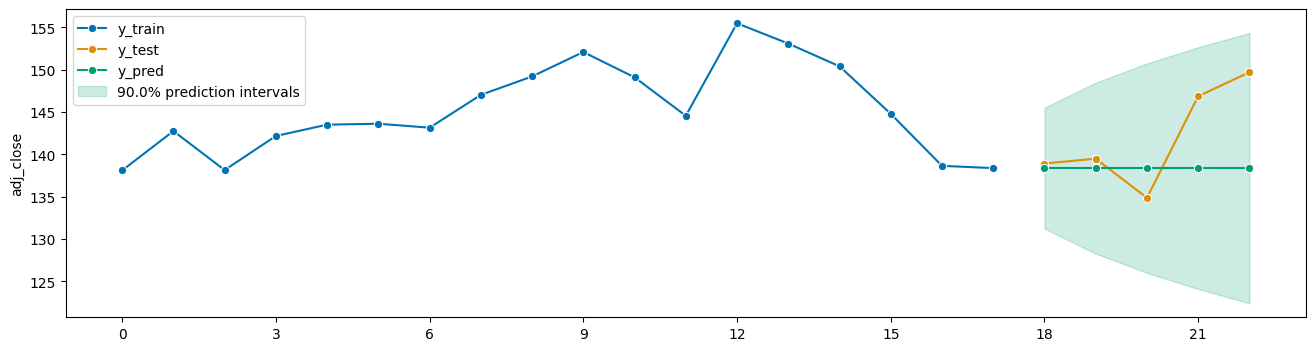

In [27]:
coverage = 0.9

y_pred = caster.predict(fh)
y_pred_intervals = caster.predict_interval(coverage=coverage)

fig, ax = plotting.plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    y_pred_intervals["Coverage"][coverage]["lower"],
    y_pred_intervals["Coverage"][coverage]["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{coverage * 100}% prediction intervals",
)
ax.legend();

### Step 3: Specify the evaluation metric and
### Step 4: Compute the forecast performance.
These can be separated by using an object version of the chosen metric, where customisations can be made before evaluation

In [28]:
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.0342729727977642

### Step 5: Test model performance against a benchmark (TODO).

In [20]:
df = raw_df.copy()

df = df.reset_index()
df.rename(columns={c: c.lower().replace(" ", "_") for c in df.columns}, inplace=True)

df["prev_close"] = df["adj_close"].shift(1)
df = df.filter(["date", "stock", "adj_close", "prev_close"]).dropna()
df.head(5)

,date,adj_close,prev_close
1,2022-10-11 00:00:00-04:00,138.749832,140.187439
2,2022-10-12 00:00:00-04:00,138.110886,138.749832
3,2022-10-13 00:00:00-04:00,142.753204,138.110886
4,2022-10-14 00:00:00-04:00,138.150833,142.753204
5,2022-10-17 00:00:00-04:00,142.174164,138.150833


In [21]:
df = df.assign(day=df["date"].dt.weekday, week=df["date"].dt.isocalendar().week, month=df["date"].dt.month, year=df["date"].dt.year)
df = df.drop(columns="date")
df.head(5)

,adj_close,prev_close,day,week,month,year
1,138.749832,140.187439,1,41,10,2022
2,138.110886,138.749832,2,41,10,2022
3,142.753204,138.110886,3,41,10,2022
4,138.150833,142.753204,4,41,10,2022
5,142.174164,138.150833,0,42,10,2022
